# Statistical Analysis 

Analyzing the significance of the differences between the modified Still Face Paradigm conditions.

In [82]:
import json 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from hypyp import stats 
import seaborn as sns
from statannot import add_stat_annotation
import scikit_posthocs as sp
import pandas as pd
from ordered_set import OrderedSet

# Infant Alpha band (6-9 Hz) analysis

In [83]:
# f = open('results_alpha_plv.json')
f = open("validated_results_alpha_pli.json")

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_alpha = []
sf1_alpha = []
fp2_alpha = []
sf2_alpha = []
ru_alpha = []

all_stages = [fp1_alpha, sf1_alpha, fp2_alpha, sf2_alpha, ru_alpha]
participant_indices = []
for part, stages in results.items():
    if part == '623' or part == '802':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))
        participant_indices.append(part)

participant_indices = np.array(OrderedSet(participant_indices))

sf2_alpha = [0 if str(x) == 'nan' else x for x in sf2_alpha]

for i in all_stages:
    print(len(i))
data_alpha = [np.array(fp1_alpha), np.array(sf1_alpha), np.array(fp2_alpha), np.array(sf2_alpha), np.array(ru_alpha)] 

33
33
33
33
33


In [84]:
import csv

data_alpha = np.column_stack((participant_indices, fp1_alpha, sf1_alpha, fp2_alpha, sf2_alpha, ru_alpha))

# Define the column names
column_names = ["fp1", "sf1", "fp2", "sf2", "reunion"]

# Define the filename for the CSV file
filename = "validated_data_alpha_pli.csv"

with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(column_names)

    writer.writerows(data_alpha)

### Descriptive analysis

In [85]:
descriptives = {'Mean': [],
                'SD': [],
                'Min': [],
                'Max': []}

for condition in all_stages: 
    descriptives['Mean'].append(round(np.mean(condition), 4))
    descriptives['SD'].append(round(np.std(condition), 4))
    descriptives['Min'].append(round(np.min(condition), 4))
    descriptives['Max'].append(round(np.max(condition), 4))

descriptives_df = pd.DataFrame(descriptives)
descriptives_df.insert(0, 'Condition', ['Free Play 1', 'Still Face 1', 'Free Play 2',
                                        'Still Face 2', 'Reunion'])

descriptives_df.to_latex('synchrony_descriptives_alpha.tex')
descriptives_df

/tmp/ipykernel_7603/1220507243.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptives_df.to_latex('synchrony_descriptives_alpha.tex')


,Condition,Mean,SD,Min,Max
0,Free Play 1,0.2136,0.0065,0.2013,0.2336
1,Still Face 1,0.2141,0.0079,0.2005,0.2303
2,Free Play 2,0.2137,0.0079,0.1958,0.2404
3,Still Face 2,0.2120,0.0069,0.1982,0.2280
4,Reunion,0.2159,0.0094,0.1966,0.2333


# Test Normality of Distribution

In [86]:
import pandas as pd
import pingouin as pg
from scipy.stats import shapiro

# Load data
df = pd.DataFrame({"FreePlay1": fp1_alpha,
                  "StillFace1": sf1_alpha,
                  "FreePlay2": fp2_alpha,
                  "StillFace2": sf2_alpha,
                  'Reunion': ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_alpha = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_alpha.columns = ['id', 'Condition', 'Synchrony']

# grouped = df_melted.groupby(["condition"])

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_alpha["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9887709617614746
p =  0.21306730806827545 -> data is normally distributed


## Main Effect: Reapeated Measures ANOVA

In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming you have a pandas DataFrame named df_melted_alpha containing the data

# Fit a repeated measures ANOVA model
model = ols('Synchrony ~ Condition', data=df_melted_alpha).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

             sum_sq     df         F    PR(>F)
Condition  0.000267    4.0  1.070145  0.373154
Residual   0.009992  160.0       NaN       NaN


## Post Hoc Analysis: Wilcoxon Signed-Rank Test 

In [88]:
import numpy as np
from scipy import stats
import scikit_posthocs as sp

# Perform Wilcoxon signed-rank test and compute z-values
def get_z_values(data, groups):
    z_values = np.zeros((len(groups), len(groups)))

    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if j >= i:
                continue
            x = data[data['Condition'] == group1]['Synchrony']
            y = data[data['Condition'] == group2]['Synchrony']
            result = stats.wilcoxon(x, y,  zero_method='zsplit')
            z_values[i, j] = result.statistic
            z_values[j, i] = -result.statistic

    return z_values

# Perform post-hoc test and adjustment
posthoc_result_alpha = sp.posthoc_wilcoxon(a=df_melted_alpha, val_col="Synchrony", group_col="Condition", p_adjust='fdr_tsbky')

# Compute z-values
z_values_alpha = get_z_values(df_melted_alpha, posthoc_result_alpha.index)

print("Post-hoc test result:")
print(posthoc_result_alpha)
print("Z-values:")
print(z_values_alpha)


Post-hoc test result:
            FreePlay1  StillFace1  FreePlay2  StillFace2   Reunion
FreePlay1    1.000000    0.876081   1.000000    0.550404  0.550404
StillFace1   0.876081    1.000000   0.673948    0.550404  0.550404
FreePlay2    1.000000    0.673948   1.000000    0.550404  0.550404
StillFace2   0.550404    0.550404   0.550404    1.000000  0.465575
Reunion      0.550404    0.550404   0.550404    0.465575  1.000000
Z-values:
[[   0. -262. -278. -222. -193.]
 [ 262.    0. -243. -229. -229.]
 [ 278.  243.    0. -229. -210.]
 [ 222.  229.  229.    0. -168.]
 [ 193.  229.  210.  168.    0.]]


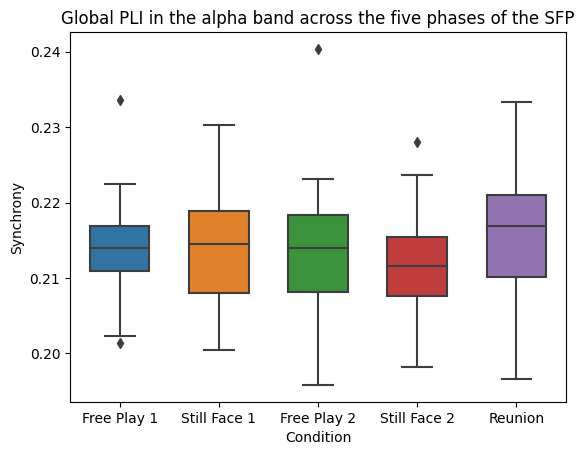

In [89]:
ax = sns.boxplot(data = df_melted_alpha, x = 'Condition', y = 'Synchrony', width = 0.6)
ax.set_title('Global PLI in the alpha band across the five phases of the SFP')
ax.set_xticklabels(['Free Play 1', 'Still Face 1', 'Free Play 2', 'Still Face 2', 'Reunion'])

ax.figure.savefig("alpha_results_pli.png") 

# Infant Theta Band (3-5 Hz) Analysis

In [90]:
f = open("validated_results_theta_pli.json")

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_theta = []
sf1_theta = []
fp2_theta = []
sf2_theta = []
ru_theta = []

all_stages = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta]
for part, stages in results.items():
    if part == '623' or part == '802':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))

sf2_theta = [0 if str(x) == 'nan' else x for x in sf2_theta]

data_theta = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta] 
data_theta = [np.array(x) for x in data_theta]

f.close()

In [91]:
import csv
data_theta = np.column_stack((participant_indices, fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta))

# Define the column names
column_names = ["participant", "fp1", "sf1", "fp2", "sf2", "reunion"]

# Define the filename for the CSV file
filename = "validated_data_theta_pli.csv"

with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(column_names)

    writer.writerows(data_theta)

## Descriptive Statistics

In [92]:
descriptives = {'Mean': [],
                'SD': [],
                'Min': [],
                'Max': []}

for condition in all_stages: 
    descriptives['Mean'].append(round(np.mean(condition), 4))
    descriptives['SD'].append(round(np.std(condition), 4))
    descriptives['Min'].append(round(np.min(condition), 4))
    descriptives['Max'].append(round(np.max(condition), 4))

descriptives_df = pd.DataFrame(descriptives)
descriptives_df.insert(0, 'Condition', ['Free Play 1', 'Still Face 1', 'Free Play 2',
                                        'Still Face 2', 'Reunion'])

descriptives_df.to_latex('synchrony_descriptives_theta.tex')
descriptives_df

/tmp/ipykernel_7603/222204992.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptives_df.to_latex('synchrony_descriptives_theta.tex')


,Condition,Mean,SD,Min,Max
0,Free Play 1,0.2379,0.0091,0.2207,0.2610
1,Still Face 1,0.2368,0.0100,0.2190,0.2621
2,Free Play 2,0.2438,0.0100,0.2296,0.2660
3,Still Face 2,0.2441,0.0132,0.2317,0.3053
4,Reunion,0.2431,0.0108,0.2163,0.2657


In [93]:
# Load data
df = pd.DataFrame({"FreePlay1": fp1_theta,
                  "StillFace1": sf1_theta,
                  "FreePlay2": fp2_theta,
                  "StillFace2": sf2_theta,
                  'Reunion': ru_theta
                  })


# Create a multi-indexed dataframe
df_melted_theta = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_theta.columns = ['id', 'Condition', 'Synchrony']

stat, p = shapiro(df_melted_theta["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.934256911277771
p-value =  7.099230856510985e-07 -> data is non-normally distributed


## Fisher Z-Transform

In [94]:
# Perform the Fisher z-transform
z_fp1_theta = np.arctanh(fp1_theta)
z_sf1_theta = np.arctanh(sf1_theta)
z_fp2_theta = np.arctanh(fp2_theta)
z_sf2_theta = np.arctanh(sf1_theta)
z_ru_theta = np.arctanh(ru_theta)

# Load data
df = pd.DataFrame({"FreePlay1": z_fp1_theta,
                  "StillFace1": z_sf1_theta,
                  "FreePlay2": z_fp2_theta,
                  "StillFace2": z_sf2_theta,
                  'Reunion': z_ru_theta
                  })


# Create a multi-indexed dataframe
df_melted_z = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_z.columns = ['id', 'Condition', 'Synchrony']

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_z["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9878281354904175
p =  0.16366101801395416 -> data is normally distributed


## Main Effect: Friedman Test

In [95]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming you have a pandas DataFrame named df_melted_alpha containing the data

# Fit a repeated measures ANOVA model
model = ols('Synchrony ~ Condition', data=df_melted_z).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

             sum_sq     df         F    PR(>F)
Condition  0.001761    4.0  3.794533  0.005631
Residual   0.018565  160.0       NaN       NaN


## Post Hoc: Wilcoxon Signed-Rank Test

In [96]:
import scikit_posthocs as sp

# Perform post-hoc test and adjustment
posthoc_result_theta = sp.posthoc_wilcoxon(a=df_melted_z, val_col="Synchrony", group_col="Condition", zero_method='zsplit', p_adjust='fdr_tsbky')

# Compute z-values
z_values_theta = get_z_values(df_melted_z, posthoc_result_theta.index)

print("Post-hoc test result:")
print(posthoc_result_theta)
print("Z-values:")
print(z_values_theta)


Post-hoc test result:
            FreePlay1  StillFace1  FreePlay2  StillFace2   Reunion
FreePlay1    1.000000    0.326157   0.012793    0.326157  0.015285
StillFace1   0.326157    1.000000   0.012793    0.420000  0.012793
FreePlay2    0.012793    0.012793   1.000000    0.012793  0.420000
StillFace2   0.326157    0.420000   0.012793    1.000000  0.012793
Reunion      0.015285    0.012793   0.420000    0.012793  1.000000
Z-values:
[[   0.  -252.  -145.  -252.  -153. ]
 [ 252.     0.  -146.  -280.5 -145. ]
 [ 145.   146.     0.  -146.  -280. ]
 [ 252.   280.5  146.     0.  -145. ]
 [ 153.   145.   280.   145.     0. ]]


/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FreePlay2 v.s. StillFace2: Custom statistical test, P_val:1.279e-02


StillFace2 v.s. Reunion: Custom statistical test, P_val:1.279e-02
FreePlay1 v.s. FreePlay2: Custom statistical test, P_val:1.279e-02
StillFace1 v.s. Reunion: Custom statistical test, P_val:1.279e-02
StillFace1 v.s. Reunion: Custom statistical test, P_val:1.279e-02
FreePlay1 v.s. Reunion: Custom statistical test, P_val:1.528e-02


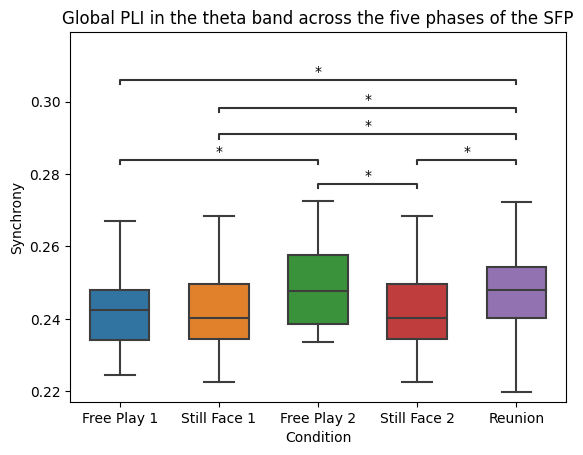

In [97]:
ax = sns.boxplot(data = df_melted_z, x = 'Condition', y = 'Synchrony', width = 0.6)
ax.set_title('Global PLI in the theta band across the five phases of the SFP')
ax.set_xticklabels(['Free Play 1', 'Still Face 1', 'Free Play 2', 'Still Face 2', 'Reunion'])
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_z, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [("FreePlay1", "FreePlay2"), ('FreePlay1', 'Reunion'), 
                                 ("StillFace1", "Reunion"), ('StillFace1', "Reunion"),
                                 ("FreePlay2", "StillFace2"),
                                 ('StillFace2', "Reunion")
                                 ],
                    perform_stat_test=False,
                    pvalues=[0.012793, 0.015285, 0.012793, 0.012793, 0.012793, 0.012793],
                    text_format = 'star',
)

ax.figure.savefig("theta_results_pli.png") 

## Calculating the % of the data kept after validation

In [98]:
with open("validated_results_alpha_pli.json") as f:
    results_theta = json.load(f)

epochs = 0
percent_kept = [0, 0, 0, 0, 0]
for part, stages in results_theta.items():
    for stage, data in stages.items():
        stage = int(stage[1]) - 1
        epochs += np.array(data).shape[0]
        nan_count = np.count_nonzero(np.isnan(np.array(data)))
        nonnan_count = np.count_nonzero(~np.isnan(np.array(data)))
        percent_kept[stage - 1] = nonnan_count/(nonnan_count+nan_count)
            
    
print(np.mean(percent_kept))

0.9523148148148148


In [99]:
import json
import numpy as np

with open("validated_results_theta_pli.json") as f:
    results_theta = json.load(f)

epochs = 0
percent_kept = [0, 0, 0, 0, 0]
for part, stages in results_theta.items():
    for stage, data in stages.items():
        stage = int(stage[1]) - 1
        epochs += np.array(data).shape[0]
        nan_count = np.count_nonzero(np.isnan(np.array(data)))
        nonnan_count = np.count_nonzero(~np.isnan(np.array(data)))
        percent_kept[stage - 1] = nonnan_count/(nonnan_count+nan_count)
            
    
print(np.mean(percent_kept))

0.952951388888889
